In [2]:
import numpy as np 
import pandas as pd 
import seaborn as sns 
from matplotlib import pyplot as plt 
import plotly.express as px

<h2 style = "color:green"> Steps Need to Follow </h2>

| Step | Description                                   |
| ---- | --------------------------------------------- |
| 1    | Center data (zero mean)                       |
| 2    | Compute covariance matrix                     |
| 3    | Compute eigenvalues & eigenvectors            |
| 4    | Sort eigenvectors by eigenvalues (descending) |
| 5    | Select top-k eigenvectors                     |
| 6    | Project original data onto new subspace       |


## make a dataset

In [10]:
data = {
    'x1': [2, 4, 6],
    'x2': [1, 3, 5],
    'x3': [10, 15, 20]
}
df = pd.DataFrame(data)

In [11]:
df.head()

,x1,x2,x3
0,2,1,10
1,4,3,15
2,6,5,20


In [12]:
df.values

array([[ 2,  1, 10],
       [ 4,  3, 15],
       [ 6,  5, 20]], dtype=int64)

## 📌 Why Centering is Required in PCA

In PCA, we want to find the directions (vectors ```𝑢```) that maximize ```variance from the origin```.  
To do that, we must ```move the center of the data to the origin```.

### 🧮 Covariance Matrix:
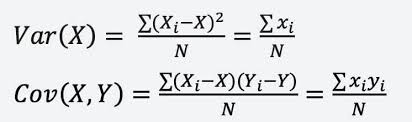

---
- If we ```don't center``` the data, this covariance matrix will be ```biased and incorrect```.
- The ```principal components``` (eigenvectors) will then ```not capture``` the true directions of ```maximum variance```.

---

## 🔶 Why Not Always Standardize?

```Standardization``` scales each feature to ```unit variance``` — this is only useful when features have ```different units or scales```.

---

### 🔸 Examples:

| **Scenario**                                | **Standardization Needed?** | **Why?**                             |
|---------------------------------------------|-------------------------------|------------------------------------|
| Height (cm), Weight (kg)                    | ✅ Yes                       | Different scales (e.g., 180 vs 70)  |
| All features already on similar scales 
| (e.g., pixel values) | ❌ No                | Scaling not needed           |                                     |

---


## Standarize/Center the Data

In [13]:
# Doing mean centering

# Convert the DataFrame in a numpy array 
X = df.values
# Center the data using mean centering 
X_meaned = X - np.mean(X , axis = 0)

In [14]:
X_meaned

array([[-2., -2., -5.],
       [ 0.,  0.,  0.],
       [ 2.,  2.,  5.]])

## Step 3: Compute Covariance Matrix 
- S = (1 / n) * Z * Z_tranpose
- Where ```Z``` is the centered data 

In [15]:
cov_matrix = np.cov(X_meaned , rowvar = False)

In [16]:
cov_matrix.shape # (d x d)

(3, 3)

## Step 4: Compute Eigenvalues and Eigenvectors

In [17]:
eigenValues , eigenVectors = np.linalg.eigh(cov_matrix) # eigh: cause our cov_matrix is symmetric

In [18]:
eigenValues

array([2.31581754e-15, 4.78960982e-15, 3.30000000e+01])

In [19]:
eigenVectors

array([[-0.66286797,  0.66286797,  0.34815531],
       [-0.5651021 , -0.74796223,  0.34815531],
       [ 0.49118803,  0.03403771,  0.87038828]])

## Step 5: Sort by Largest Eigenvalues 

In [20]:
# Sort eigenvalues and corresponding eigenvectors
sorted_indices = np.argsort(eigenValues)[ : : -1] # Sorting indices based on their max eigen values and then descending order

eigenValues = eigenValues[sorted_indices]
eigenVectors = eigenVectors[ : , sorted_indices]

In [21]:
eigenValues

array([3.30000000e+01, 4.78960982e-15, 2.31581754e-15])

In [22]:
eigenVectors

array([[ 0.34815531,  0.66286797, -0.66286797],
       [ 0.34815531, -0.74796223, -0.5651021 ],
       [ 0.87038828,  0.03403771,  0.49118803]])

## Step 6: Select Top k Eigenvectors

In [23]:
k = 2 # desired lower dimension of data
eigenVectors_k = eigenVectors[ : , : k] # shape(d x k) 

## Step 7: Project Data onto New Subspace

- ```X_reduced = X_meaned.eigenVectos_k```

In [24]:
# Project original data 
X_reduced = np.dot(X_meaned , eigenVectors_k)

In [25]:
X_meaned.shape

(3, 3)

In [26]:
X_reduced.shape

(3, 2)

## A new dataset

In [27]:
np.random.seed(23)

mu_vec1 = np.array([0, 0, 0])
cov_mat1 = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]])
class1_sample = np.random.multivariate_normal(mu_vec1, cov_mat1, 20)

df = pd.DataFrame(class1_sample, columns=['feature1', 'feature2', 'feature3'])
df['target'] = 1

mu_vec2 = np.array([1, 1, 1])
cov_mat2 = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]])
class2_sample = np.random.multivariate_normal(mu_vec2, cov_mat2, 20)

df1 = pd.DataFrame(class2_sample, columns=['feature1', 'feature2', 'feature3'])
df1['target'] = 0


df = pd.concat([df, df1], ignore_index=True)

# Shuffle the DataFrame
df = df.sample(40).reset_index(drop=True)

In [28]:
df.head()

,feature1,feature2,feature3,target
0,-0.367548,-1.137460,-1.322148,1
1,0.177061,-0.598109,1.226512,0
2,0.420623,0.411620,-0.071324,1
3,1.968435,-0.547788,-0.679418,1
4,-2.506230,0.146960,0.606195,1


In [29]:
plt.figure(figsize = (8 , 8))
fig = px.scatter_3d(df, x=df['feature1'], y=df['feature2'], z=df['feature3'],
              color=df['target'].astype('str'))
fig.update_traces(marker=dict(size=12,
                              line=dict(width=2,
                                        color='DarkSlateGrey')),
                  selector=dict(mode='markers'))

fig.show()

<Figure size 800x800 with 0 Axes>

## Full Implementation

In [30]:
class PCA:
    """
        Principal Component Analysis (PCA)
    
        Parameters
        ----------
        n_components : int
            Number of principal components to retain.
    
        Attributes
        ----------
        components_ : ndarray of shape (n_components, n_features)
            Principal axes in feature space.
    
        mean_ : ndarray of shape (n_features,)
            Feature-wise mean of the training data.
    
        explained_variance_ : ndarray of shape (n_components,)
            Variance explained by each selected component.
    
        explained_variance_ratio_ : ndarray of shape (n_components,)
            Percentage of variance explained by each selected component.
    
        feature_names_in_ : list of str
            Original column names if input was a DataFrame.
    """
    def __init__(self , n_components):
        self.n_components = n_components
        self.components_ = None
        self.mean_ = None
        self.explained_variance_ = None 
        self.explained_variance_ratio_ = None 
        self.feature_names_in_ = None 
        
    def _ensure_array(self , X): 
        """ 
        Convert DataFrame to Numpy array if necessary. Store the columns name
        """
        if isinstance(X , pd.DataFrame): 
            # convert into numpy array 
            self.feature_names_in_ = X.columns.tolist()    
            return X.to_numpy() # We need just the value
        
        self.feature_names_in_ = None
        return X 
    def fit(self , X): 
        """
        Fit PCA to the dataset.

        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            Training data.

        Returns
        -------
        self : object
        """
        # If X is not a numpy array then convert it
        X = self._ensure_array(X)
        
        # Step-1: Center the Data(Mean Centered)
        self.mean_ = np.mean(X , axis = 0) # mean value of each column
        X_centered = X - self.mean_
        
        # Step 2: Compute the covariance matrix
        cov_matrix = np.cov(X_centered , rowvar = False) 
        
        # Step 3: Eigen decomposition(Find the eeigenValues and eeigenVectors)
        eigenValues , eigenVectors = np.linalg.eigh(cov_matrix)
        
        # Step 4: Sort by descending eigenvalues
        sorted_indices = np.argsort(eigenValues)[ : : -1]
        
        # Step 5: Select the top k components
        self.components_ = eigenVectors[ : , : self.n_components]
        self.explained_variance_ = eigenValues[ : self.n_components]
        self.explained_variance_ratio_ = self.explained_variance_ / np.sum(eigenValues)

        return self
    def transform(self , X): 
        """
        Project X onto principal components.

        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            Data to transform.

        Returns
        -------
        X_transformed : DataFrame of shape (n_samples, n_components)
            Transformed data as a DataFrame.
        """
        # Save the column naming
        X_input = X 
        X = self._ensure_array(X)

        # center the data 
        X_centered = X - self.mean_
        X_transformed = np.dot(X_centered , self.components_)

        col_names = [f"PC{i + 1}" for i in range(self.n_components)] 
        return pd.DataFrame(X_transformed, columns=col_names, index=getattr(X_input, "index", None))
    def fit_transform(self, X):
        """
        Fit to data, then transform it.

        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            Data to fit and transform.

        Returns
        -------
        X_transformed : DataFrame of shape (n_samples, n_components)
            Transformed data.
        """
        return self.fit(X).transform(X)


In [31]:
from sklearn.datasets import load_iris
import pandas as pd

iris = load_iris()
df = pd.DataFrame(iris.data, columns=iris.feature_names)

pca = PCA(n_components=2)
df_pca = pca.fit_transform(df)

print(df_pca.head())

        PC1       PC2
0  0.002262  0.027915
1  0.099027  0.210464
2  0.019968 -0.017900
3 -0.075576 -0.031559
4 -0.061259 -0.090079


<h2 style = "color: green;">PCA class attributes</h2>

### components_:

 - This attribute is an array of shape (n_components, n_features).
    It represents the principal axes in feature space, or the directions of maximum variance in the data.
 -  Each `row` in components_ corresponds to a `principal component`, and the values in that row are the coefficients (or "loadings") that         define how each original feature contributes to that principal component.
 -  Essentially, these are the `eigenvectors` of the covariance matrix of your original data, `sorted by their corresponding eigenvalues`.
 -   A higher absolute value of a coefficient for a particular feature in a component indicates a stronger influence of that feature on that        principal component.

In [32]:
pca.components_

array([[ 0.31548719,  0.58202985],
       [-0.3197231 , -0.59791083],
       [-0.47983899, -0.07623608],
       [ 0.75365743, -0.54583143]])

### explained_variance_ratio_ 

- This attribute is an array of shape (n_components,).
- It represents the `percentage of variance explained` by each of the selected components.
- Each value in this array indicates the `proportion of the total variance` in the original dataset that is captured by that specific      principal component.
- The sum of all values in `explained_variance_ratio_ will be 1.0` (or very close to 1.0 due to floating-point precision) if n_components is set to None (meaning all components are kept), or if n_components is equal to the number of original features. If n_components is less than the total number of features, the sum will be less than 1.0, indicating the proportion of variance retained.
- It's a crucial metric for deciding how many principal components to keep, as you often want to retain enough components to explain a significant portion of the total variance (e.g., 95%).

In [34]:
pca.explained_variance_

array([0.02383509, 0.0782095 ])

In [35]:
np.sum(pca.explained_variance_)

0.10204459301636881

### explained_variance_:

- This attribute is an array of shape (n_components,).
- It represents the amount of variance explained by each of the selected components.
- These values are the `eigenvalues` of the covariance matrix of the original data, `corresponding to each principal component`.
- explained_variance_ gives the absolute variance captured by each component, while explained_variance_ratio_ normalizes these values by the total variance to give you a proportion.
- The relationship between the two is: `explained_variance_ratio_[i] = explained_variance_[i] / np.sum(explained_variance_)` (where the sum is over all components in the original dataset, not just the selected ones if n_components was set to less than the total features).

In [36]:
pca.explained_variance_

array([0.02383509, 0.0782095 ])